## Transformer, Self-Attention и моделирование языка для датасета public.ru

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import traceback
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from pymongo import MongoClient
import bs4
import datetime
import copy
import logging
import os
from tqdm.notebook import tqdm
from IPython.display import clear_output
import youtokentome as yttm

import simcube
from simcube.data import tokenize_corpus, build_vocabulary, \
    save_texts_to_file, LanguageModelDataset, load_war_and_piece_chunks, \
    GreedyGenerator, BeamGenerator
from simcube.pipeline import train_eval_loop, init_random_seed
from simcube.base import get_params_number

init_random_seed()

plt.rcParams["figure.figsize"] = (15,10)

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
raw_data_path = os.path.join("..", "..", "data", "raw")
processed_data_path = os.path.join("..", "..", "data", "processed")
models_path = os.path.join("..", "..", "models")
experiments_path = os.path.join("..", "..", "experiments")

In [4]:
client = MongoClient('localhost', 27017)
db = client.publicru_test
collection = db.documents_collection

In [5]:
def load_war_and_piece_chunks(fname, chunk_size=200):
    with open(fname, 'r') as fin:
        full_text = fin.read()
    return [full_text[start:start + chunk_size] for start in range(0, len(full_text), chunk_size // 2)]


def save_texts_to_file(texts, out_file):
    with open(out_file, 'w') as outf:
        outf.write('\n'.join(texts))

### Получение текста из тела статьи

In [6]:
def get_text(post, chunk_size=300):
    full_text = []
    paras_tags = ["h1", "h2", "h3", "h4", "h5", "h6", "p", "li"]
    soup = bs4.BeautifulSoup(str(post), "lxml")
    for element in soup.find_all(paras_tags):
        full_text.append(element.text)
    soup.decompose()
    full_text = " ".join(full_text)
    return [full_text[start:start + chunk_size] for start in range(0, len(full_text), chunk_size // 2)]
     

In [7]:
def save_texts_to_file(texts, file_name):
    with open(file_name, 'w') as outf:
        outf.write('\n'.join(texts))

In [8]:
def load_texts_from_file(file_name):
    with open(file_name, 'r') as outf:
        return outf.readlines()

тестирование:

In [9]:
result = collection.find({}, {"body": 1}).skip(1000).limit(1)
document = result[0]

In [10]:
document

{'_id': ObjectId('5e7854ecc59124ce04bed321'),
 'body': '<body><p>Аукцион</p>\n<p>РУБРИКУ ВЕДЕТ ИНФОРМАЦИОННЫЙ ЦЕНТР «Ъ»</p>\n<p>РИСУНКИ СЕРГЕЯ ГОЛОСОВА</p>\n<p>Покупатели любят общаться с интернет-магазинами.</p>\n<p>По данным последнего опроса, проведенного Facebook, больше половины потребителей предпочитают делать онлайн-покупки через сайты с функцией чата. Вывод - коммуникация B2C через мессенджеры набирает силу и не собирается замедляться в будущем. 63% респондентов, пользующихся мессенджерами в коммерческих целях, сказали, что посылают такие сообщения чаще, чем два года назад. 67% ожидают более активной переписки в следующие два года. Кроме того, использование приложений для переписки не является более прерогативой молодых. 65% миллениалов предпочитают мессенджеры звонкам и почте. От них не отстают родители, поколение Х, - те же 65%, и практически вровень идут бебибумеры (родившиеся после Второй мировой войны) - 63%. Покупатели любят пользоваться услугой обратной связи из-за быстр

In [11]:
get_text(document['body'])

['Аукцион РУБРИКУ ВЕДЕТ ИНФОРМАЦИОННЫЙ ЦЕНТР «Ъ» РИСУНКИ СЕРГЕЯ ГОЛОСОВА Покупатели любят общаться с интернет-магазинами. По данным последнего опроса, проведенного Facebook, больше половины потребителей предпочитают делать онлайн-покупки через сайты с функцией чата. Вывод - коммуникация B2C через месс',
 'роведенного Facebook, больше половины потребителей предпочитают делать онлайн-покупки через сайты с функцией чата. Вывод - коммуникация B2C через мессенджеры набирает силу и не собирается замедляться в будущем. 63% респондентов, пользующихся мессенджерами в коммерческих целях, сказали, что посылают ',
 'енджеры набирает силу и не собирается замедляться в будущем. 63% респондентов, пользующихся мессенджерами в коммерческих целях, сказали, что посылают такие сообщения чаще, чем два года назад. 67% ожидают более активной переписки в следующие два года. Кроме того, использование приложений для переписк',
 'такие сообщения чаще, чем два года назад. 67% ожидают более активной переписки в сл

In [54]:
DATASET_FILE = os.path.join(processed_data_path, "transformer_publicru.txt")
dataset = []
for document in collection.find({}, {"body": 1}).skip(1000).limit(10):
    dataset += get_text(document['body'])
save_texts_to_file(dataset, DATASET_FILE)

In [55]:
loaded_dataset = load_texts_from_file(DATASET_FILE)

In [56]:
loaded_dataset = list(map(lambda x: x.strip(), loaded_dataset))
loaded_dataset = list(map(lambda x: x.lower(), loaded_dataset))

In [57]:
loaded_dataset

['аукцион рубрику ведет информационный центр «ъ» рисунки сергея голосова покупатели любят общаться с интернет-магазинами. по данным последнего опроса, проведенного facebook, больше половины потребителей предпочитают делать онлайн-покупки через сайты с функцией чата. вывод - коммуникация b2c через месс',
 'роведенного facebook, больше половины потребителей предпочитают делать онлайн-покупки через сайты с функцией чата. вывод - коммуникация b2c через мессенджеры набирает силу и не собирается замедляться в будущем. 63% респондентов, пользующихся мессенджерами в коммерческих целях, сказали, что посылают',
 'енджеры набирает силу и не собирается замедляться в будущем. 63% респондентов, пользующихся мессенджерами в коммерческих целях, сказали, что посылают такие сообщения чаще, чем два года назад. 67% ожидают более активной переписки в следующие два года. кроме того, использование приложений для переписк',
 'такие сообщения чаще, чем два года назад. 67% ожидают более активной переписки в сле

In [13]:
DATASET_FILE = os.path.join(processed_data_path, "transformer_publicru.txt")
PROCESSED_DATASET_FILE = os.path.join(processed_data_path, "processed_transformer_publicru.txt")

In [14]:
%%time

dataset = []
MONGODB_FILTER = {"edition_name": { "$in": ["РБК Журнал", "Российская газета"]},}
for document in tqdm(collection.find(MONGODB_FILTER, {"body": 1}), desc="Parce documents", total=collection.count_documents(MONGODB_FILTER)):
    dataset += get_text(document['body'])
save_texts_to_file(dataset, DATASET_FILE)


CPU times: user 1min 18s, sys: 1.6 s, total: 1min 20s
Wall time: 1min 22s


In [50]:
!ls -lah ../../data/processed | grep "publicru"

-rw-rw-r-- 1 science science 5,6G Apr  5 14:17 processed_transformer_publicru.txt
-rw-rw-r-- 1 science science 532M Apr  6 21:30 publicru_bpe_train.txt
-rw-rw-r-- 1 science science  11K Apr  6 21:30 publicru_bpe.yttm
-rw-rw-r-- 1 science science 789M Apr  6 21:20 transformer_publicru.txt


In [29]:
loaded_dataset = load_texts_from_file(DATASET_FILE)

In [30]:
%%time
loaded_dataset = [post for post in loaded_dataset if len(post) > 290]
loaded_dataset = list(map(lambda x: x.strip(), loaded_dataset))
loaded_dataset = list(map(lambda x: x.lower(), loaded_dataset))

CPU times: user 3.41 s, sys: 0 ns, total: 3.41 s
Wall time: 3.4 s


In [31]:
len(loaded_dataset)

1454919

In [32]:
np.random.shuffle(loaded_dataset)

In [33]:
TRAIN_SPLIT = int(len(loaded_dataset) * 0.7)
train_texts = loaded_dataset[:TRAIN_SPLIT]
test_texts = loaded_dataset[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 1018443
Размер валидационной выборки 436476


In [38]:
VOCAB_SIZE = 1000
BPE_MODEL_FILENAME = '../../data/processed/publicru_bpe.yttm'
TRAIN_TEXTS_FILENAME = '../../data/processed/publicru_bpe_train.txt'

In [39]:
save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=VOCAB_SIZE, model=BPE_MODEL_FILENAME);

In [40]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [41]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о е а и н т с р в л к м д п у ы я г з ь б , ч й . х ж ц ю ш - ф э щ « » 0 1 2 : 5 3 ) ( 4 7 9 6 8 * ъ e ? a i r o t s n l u c / g m p d % b h ! ; f … № v w k x y z j + $ ё q @ ' & [ ] | _ € # " ` = ° > < \ · ® ­ ™ і ћ ї ~ є © { ^ µ § } ± ¬ ▁п ▁с ▁в ст ▁н ен ов ра ▁и ▁о то но ро ко ре ▁по го ▁д ли ▁м ни ет ль ▁на ка ны ри та те за ▁б ла на ки ер ени ть ▁у да ле ▁а ти ва ▁ч ло ▁не ▁ко ся ци ▁за ми ▁э ру ▁про во ▁ра ▁« ▁к ▁- ди ем ова ви ля ес ▁со ест ▁г ▁до ▁об де си ▁ка ма ▁го ▁при ▁от ▁т мо ей по ▁во ча ▁то ры ду ▁ре ных ▁что чи ста бо ▁пре ▁е ▁мо сти хо ения ▁это ▁ф ско ▁вы же ово не ги ной тель се рос ного ▁та ку до лу жи ▁из па ют ные ▁те ши га ▁бы мен ну щи ств ере ров ту ный сь ▁ма му ты ▁раз ▁бо ▁но ▁ми чес ение ▁2 са ▁з ски ек ▁кото ве ции ме сто ▁1 росси тов лю ▁под зи ков тра нов ня ▁все пи ▁ин ▁ста ▁росси ется цен ▁да ▁для со сть ▁са ния ря м, ▁де ше ▁пред ▁ли пе ▁бу ▁как жа лов жно би », ▁я ▁ни ▁па су лен ▁ме рова мы вы ▁си сле ▁пра ▁( ще ша ▁су ке 

In [43]:
len(tokenizer.vocab())

1000

In [44]:
print(tokenizer.encode(train_texts[:1]))

[[133, 434, 471, 144, 159, 20, 140, 217, 238, 560, 14, 530, 975, 434, 604, 16, 417, 828, 350, 216, 342, 44, 127, 229, 17, 300, 292, 965, 411, 35, 5, 151, 130, 166, 927, 256, 281, 499, 127, 331, 410, 734, 35, 157, 17, 23, 362, 231, 302, 21, 232, 359, 26, 720, 304, 205, 855, 146, 126, 145, 31, 266, 171, 143, 573, 167, 612, 373, 212, 856, 137, 15, 236, 301, 736, 965, 411, 148, 177, 34, 534, 144, 537, 303, 26, 178, 17, 318, 20, 332, 148, 602, 693, 6, 181, 157, 17, 23, 362, 244, 197, 145, 237, 452, 40, 295, 258, 169, 141, 155, 394]]


In [45]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

In [53]:
len(train_token_ids)

1018443

Text(0.5, 1.0, 'Распределение длин фрагментов в токенах')

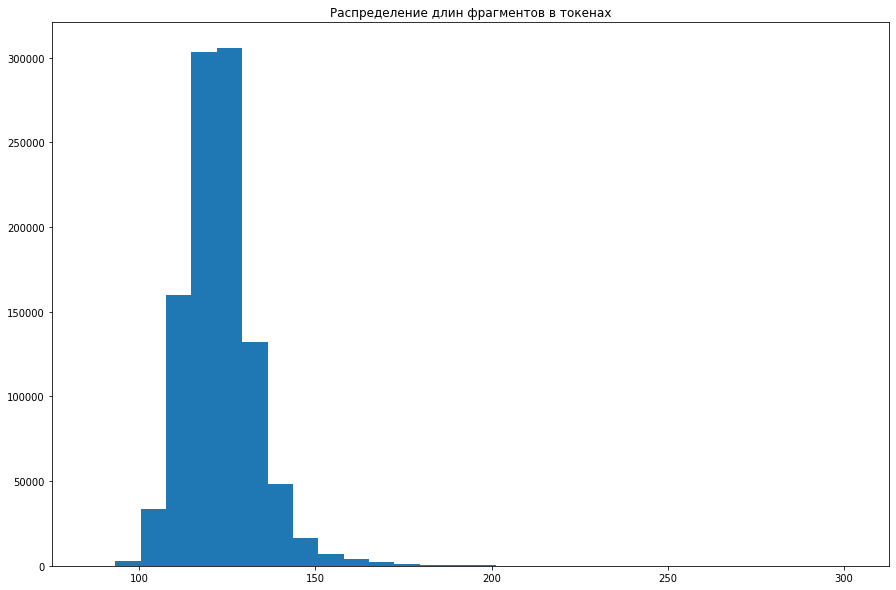

In [48]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
# plt.yscale('log');

Text(0.5, 1.0, 'Распределение количества упоминаний токенов')

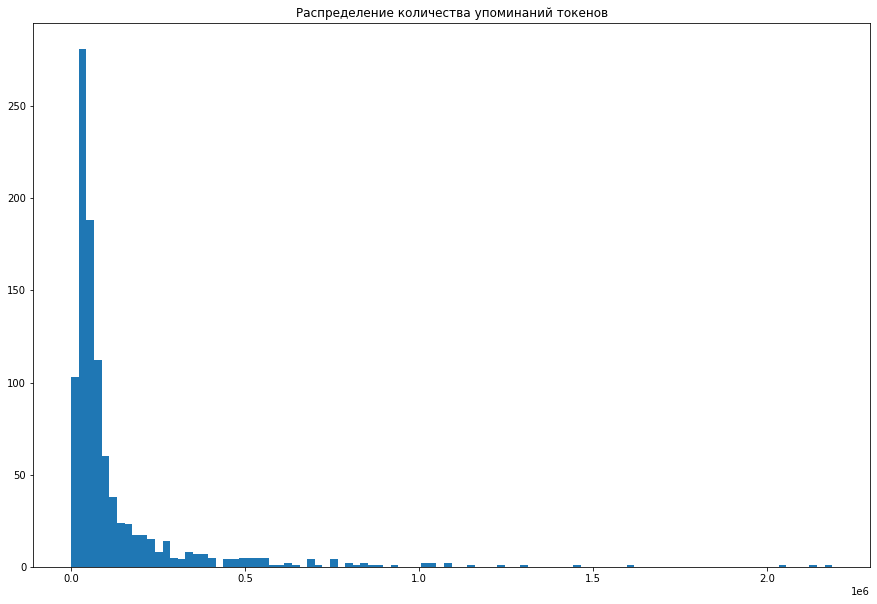

In [51]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
# plt.yscale('log');

In [52]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке', unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


In [55]:
CHUNK_LENGTH = 200

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [56]:
train_dataset[0]

(array([  2, 133, 434, 471, 144, 159,  20, 140, 217, 238, 560,  14, 530,
        975, 434, 604,  16, 417, 828, 350, 216, 342,  44, 127, 229,  17,
        300, 292, 965, 411,  35,   5, 151, 130, 166, 927, 256, 281, 499,
        127, 331, 410, 734,  35, 157,  17,  23, 362, 231, 302,  21, 232,
        359,  26, 720, 304, 205, 855, 146, 126, 145,  31, 266, 171, 143,
        573, 167, 612, 373, 212, 856, 137,  15, 236, 301, 736, 965, 411,
        148, 177,  34, 534, 144, 537, 303,  26, 178,  17, 318,  20, 332,
        148, 602, 693,   6, 181, 157,  17,  23, 362, 244, 197, 145, 237,
        452,  40, 295, 258, 169, 141, 155, 394,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [68]:
train_dataset[0][0] == 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [57]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> инимаются меры по предоставлению предпринимателям большей свободы: внедряется риск-ориентированный подход в контрольно-надзорной деятельности, который предполагает снижение количества государственных проверок там, где риск нарушений меньше, продлены так называемые «надзорные каникулы» для малого биз<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'инимаются меры по предоставлению предпринимателям большей свободы: внедряется риск-ориентированный подход в контрольно-надзорной деятельности, который предполагает снижение количества государственных проверок там, где риск нарушений меньше, продле

In [58]:
def make_target_dependency_mask(length):
    """
    Генерирует маску зависимости позиций.
    Строка соответствует номеру позиции в выходной последовательности.
    Столбцы - номерам позиий во входной последовательности.
    0 - можно учитывать, -inf - нельзя учитывать.
    Мы запрещаем модели смотреть на токены справа.
    """
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

In [59]:
make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [60]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

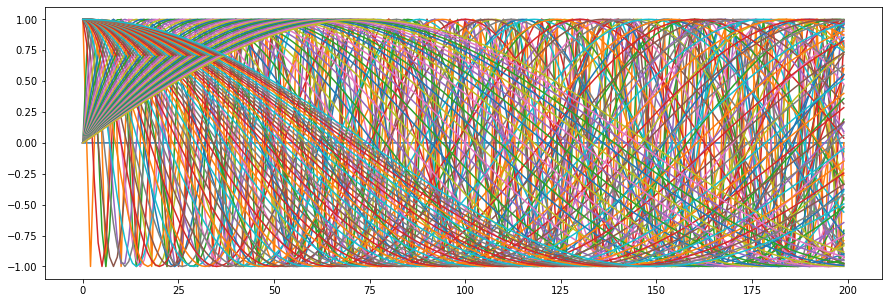

In [64]:
sample_pos_codes = make_positional_encoding(200, 300)
plt.plot(sample_pos_codes[:, ::3].numpy());
plt.gcf().set_size_inches((15, 5))

### Основной класс - языковая модель

In [75]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        # Выходной слой приводит выход модели к размеру словаря
        self.out = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        """
            seed_token_ids - BatchSize x MaxInLen
        """
        batch_size, max_in_length = seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        dependency_mask = make_target_dependency_mask(max_in_length).to(seed_token_ids.device)
        
        seed_embs = self.embeddings(seed_token_ids)  # BatchSize x MaxInLen x EmbSize
        pos_codes = make_positional_encoding(max_in_length, self.embedding_size).unsqueeze(0).to(seed_embs.device)
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        # BatchSize x TargetLen x EmbSize
        target_features = self.backbone(seed_embs, mask=dependency_mask, src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

### Утилиты для обучения - функция потерь и расписание изменения длины градиентного шага

In [76]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

## Реализация Transformer из PyTorch 1.2

In [77]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


In [85]:
def train_eval_loop(model, train_dataset, val_dataset,
                    criterion,
                    lr=1e-4,
                    epoch_n=10,
                    batch_size=32,
                    device=None,
                    early_stopping_patience=10,
                    l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Выбранное устройство: {device}")
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    history_mean_train_loss = []
    history_mean_val_loss = []  
    
    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1
                
            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n, (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format( early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            history_mean_train_loss.append(mean_train_loss)
            history_mean_val_loss.append(mean_val_loss)
    
            # visualizing training process
            if (epoch_i + 1) % 2 == 0:
                clear_output(True)
                plt.plot(history_mean_train_loss, label='train_loss')
                plt.plot(history_mean_val_loss, label='valid_loss')
                plt.legend()
                plt.show()
        
            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [86]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [87]:
torch_transf_model = LanguageModel(
    tokenizer.vocab_size(),
    256,
    BatchFirstTransformerEncoder(
       nn.TransformerEncoderLayer(
           d_model=256,
           nhead=16,
           dim_feedforward=512,
           dropout=0.3),
       num_layers=3),
    emb_dropout=0.1
)

In [88]:
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


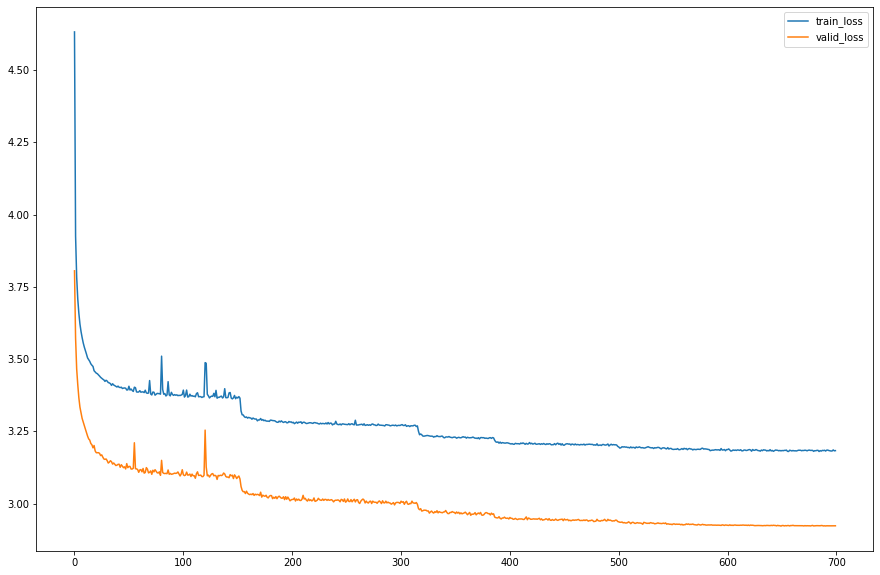


Эпоха 700
Эпоха: 1001 итераций, 155.29 сек
Среднее значение функции потерь на обучении 3.180757816021259
Среднее значение функции потерь на валидации 2.922891663504647
Модель не улучшилась за последние 50 эпох, прекращаем обучение
CPU times: user 1d 19h 25min 5s, sys: 27min, total: 1d 19h 52min 5s
Wall time: 1d 16h 38min 42s


In [89]:
%%time

best_val_loss, best_torch_transf_model = train_eval_loop(torch_transf_model, train_dataset, test_dataset,
    lm_cross_entropy,
    lr=2e-3,
    epoch_n=5000,
    batch_size=64,
    device='cuda',
    early_stopping_patience=50,
    max_batches_per_epoch_train=1000,
    max_batches_per_epoch_val=1000,
    lr_scheduler_ctor=lr_scheduler
)

In [90]:
torch.save(best_torch_transf_model.state_dict(), '../../data/models/publicru_transf_best.pth')

In [91]:
torch_transf_model.load_state_dict(torch.load('../../data/models/publicru_transf_best.pth'))

<All keys matched successfully>

In [92]:
greedy_generator = GreedyGenerator(torch_transf_model, tokenizer)

In [93]:
%%time

print(greedy_generator('сказала княжна, оглядывая бона'))

сказала княжна, оглядывая бона
CPU times: user 56.4 ms, sys: 0 ns, total: 56.4 ms
Wall time: 10 ms


In [94]:
print(greedy_generator('президент пу'))

президент пу р


In [96]:
from simcube.data import tokenize_corpus, build_vocabulary, \
    save_texts_to_file, LanguageModelDataset, load_war_and_piece_chunks, \
    GreedyGenerator, BeamGenerator

In [98]:
beam_generator = BeamGenerator(torch_transf_model, tokenizer)

In [101]:
%%time

beam_gen_variants = beam_generator('На Украине заявили о готовности к прекращению транзита газа из России'.lower(),
                                   beamsize=20,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
4.421804308891296
на украине заявили о готовности к прекращению транзита газа из россии........................................

****
4.578393578529358
на украине заявили о готовности к прекращению транзита газа из россии.......................................>

****
4.730123996734619
на украине заявили о готовности к прекращению транзита газа из россии.......................................,

****
4.735682964324951
на украине заявили о готовности к прекращению транзита газа из россии.......................................»

****
4.7366297245025635
на украине заявили о готовности к прекращению транзита газа из россии.........................>..............

CPU times: user 27.7 s, sys: 40.5 ms, total: 27.7 s
Wall time: 5 s


In [102]:
beam_gen_variants = beam_generator('На Украине'.lower(),
                                   beamsize=20,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
3.7284164428710938
на украине президент влади<EOS>

****
4.5004560977378265
на украине президент владимир путин. президен<EOS>

****
4.9158571364295085
на украине президент владимир пушкин. президент владимир путин рассказал, что президен<EOS>

****
5.050049080163229
на украине президент владимир пушкин. президент владимир путин рассказал, что президент владимир путин рассл<EOS>

****
5.094212841180709
на украине президент владимир пушкин. президент владимир путин сказал, что президен<EOS>



In [103]:
beam_gen_variants = beam_generator('На Украине заявили о готовности к прекращению транзита газа из России'.lower(),
                                   beamsize=100,
                                   return_hypotheses_n=10)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.3401302303719387
на украине заявили о готовности к прекращению транзита газа из россии стра<EOS>

****
2.598854857351011
на украине заявили о готовности к прекращению транзита газа из россииений и<EOS>

****
2.6054055781405756
на украине заявили о готовности к прекращению транзита газа из россии владиво<EOS>

****
2.646502859761322
на украине заявили о готовности к прекращению транзита газа из россии президент р<EOS>

****
2.7698303115596423
на украине заявили о готовности к прекращению транзита газа из россии президен<EOS>

****
2.786398513738192
на украине заявили о готовности к прекращению транзита газа из россиичива<EOS>

****
2.87015537704638
на украине заявили о готовности к прекращению транзита газа из россии владимир пу<EOS>

****
2.946667168971702
на украине заявили о готовности к прекращению транзита газа из россии ири<EOS>

****
3.0225704321269755
на украине заявили о готовности к прекращению транзита газа из россии кита<EOS>

****
3.025615843149401
на украине заявили